In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [15]:
import numpy as np
import matplotlib.pyplot as plt

def p1(x,r):
    y = 1/np.sqrt(2*np.pi*(r-1))*np.exp(-(x-(r-1))**2/(2*(r-1)))
    return y

def p2(x,r):
    y = np.sqrt(r/(2*np.pi))/x*np.exp(-r/2*(np.log(x/r))**2)
    return y

def p3(x,r):
    y = np.exp(-x)*x**r/np.math.factorial(r)
    return y


/Users/samsuidman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsuidman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Users/samsuidman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


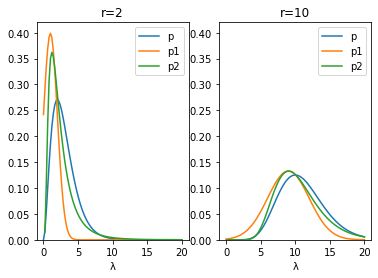

In [21]:
x = np.linspace(0,20,100)
y1_r2 = p1(x,2)
y2_r2 = p2(x,2)
y3_r2 = p3(x,2)
y1_r10 = p1(x,10)
y2_r10 = p2(x,10)
y3_r10 = p3(x,10)
fig, ax = plt.subplots(ncols=2)
ax[0].plot(x,y3_r2,label='p')
ax[0].plot(x,y1_r2,label='p1')
ax[0].plot(x,y2_r2,label='p2')
ax[1].plot(x,y3_r10,label='p')
ax[1].plot(x,y1_r10,label='p1')
ax[1].plot(x,y2_r10,label='p2')
ax[0].set_title('r=2')
ax[1].set_title('r=10')
ax[0].set_xlabel('λ')
ax[1].set_xlabel('λ')
ax[0].set_ylim([0,0.42])
ax[1].set_ylim([0,0.42])
ax[0].legend()
ax[1].legend()

In [13]:
np.math.factorial(3)

6